### Taks3_Regression Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snsa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from dm_tool import data_prep 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

%matplotlib inline

In [2]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model and feature name from the original X
    coef = model.coef_[0]
    feature_names = X.columns

    # sort them out in descending order
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    print("\n\n*********** Feature Importances ************\n")   
    for i in indices:
        print(f"{feature_names[i]:<35}:{coef[i]}")

### Data preparation and split the data set

In [3]:
# preprocessing step
df = data_prep()

# set the random seed - consistent
rs = 10

# train test split
y = df['IsBadBuy']
X = df.drop(['IsBadBuy'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\steven\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\Users\steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


## Apply transformation method to variables

###  Logarithmic transformation 

C:\Users\steven\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


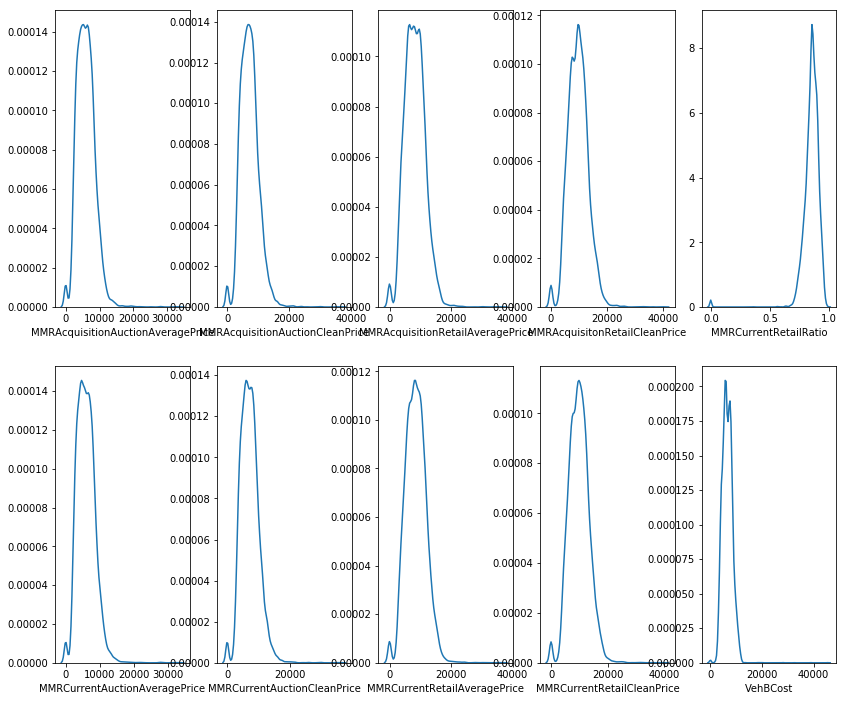

In [4]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(2,5, figsize=(14,12), sharex=False)

    # post data set
    sns.distplot(df['MMRAcquisitionAuctionAveragePrice'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['MMRAcquisitionRetailAveragePrice'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), hist=False, ax=axes[0,3])
    sns.distplot(df['MMRCurrentRetailRatio'].dropna(), hist=False, ax=axes[0,4])

    # current data set
    sns.distplot(df['MMRCurrentAuctionAveragePrice'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['MMRCurrentAuctionCleanPrice'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['MMRCurrentRetailAveragePrice'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['MMRCurrentRetailCleanPrice'].dropna(), hist=False, ax=axes[1,3])
    sns.distplot(df['VehBCost'].dropna(), hist=False, ax=axes[1,4])
    plt.show()
    
plot_skewed_columns(df)

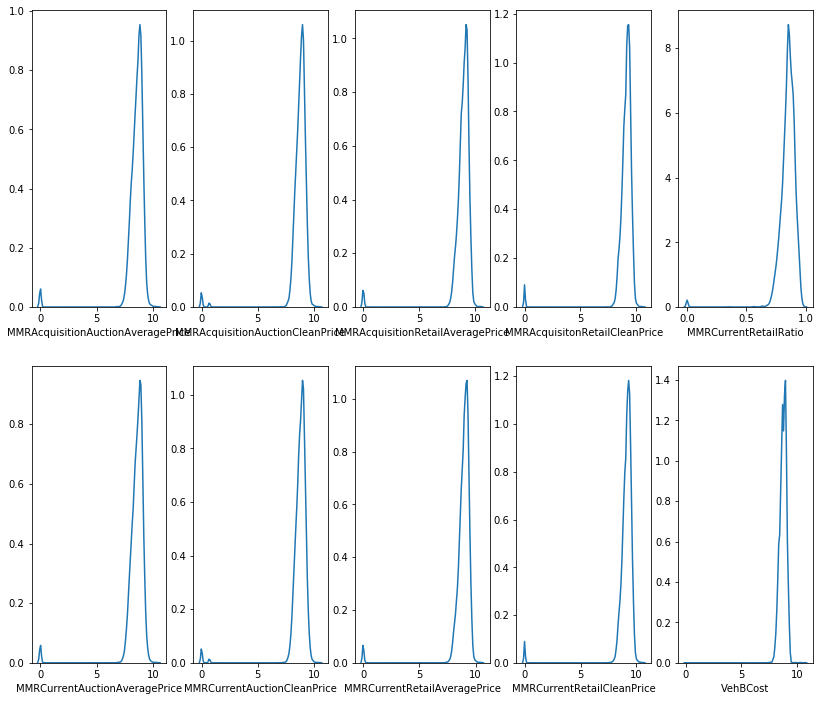

In [5]:
# normalise skewed distributions by log transformation.
import numpy as np

# list columns to be transformed
columns_to_transform = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','VehBCost']

# copy the dataframe
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

In [6]:
# create X, y and train test data partitions
y_log = df_log['IsBadBuy']
X_log = df_log.drop(['IsBadBuy'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)
# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

C:\Users\steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


### Logistic regression model construction with default setting

In [ ]:
#the dataset used in default model is modified with transformation method performed above 

# Training the model with default setting
model = LogisticRegression(random_state=rs)
# fit it to training data
model.fit(X_train_log, y_train_log)

# training and test accuracy
print("\n*********** Accuracy of the model ************\n") 
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))

# classification report on test data
# Confusion Matrix
print("\n\n*********** Confusion Matrix ************\n") 
y_pred = model.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# Feature Importance
analyse_feature_importance(model, X.columns, 20)

### Logistic regression model construction with Grid Search

In [ ]:
# grid search CV
# finding optimal hyperparameters "C" which denotes the inverse of regularisation strength.
# Smaller C means stronger regularisation

params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

# Confusion Matrix
print("\n\n*********** Confusion Matrix ************\n") 
y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

### Reculsive feature elimination - dimensionality reduction

In [7]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs, solver = 'lbfgs', max_iter = 200), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 125
Number of features after elimination 45


In [8]:
# taking only the important features
X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

In [9]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train_log))
print("Test accuracy:", cv.score(X_test_sel, y_test_log))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.8227932365863401
Test accuracy: 0.8219944082013048
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1609
           1       0.90      0.73      0.80      1610

   micro avg       0.82      0.82      0.82      3219
   macro avg       0.83      0.82      0.82      3219
weighted avg       0.83      0.82      0.82      3219

{'C': 1}


C:\Users\steven\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


###  Feature selection using decision tree model

In [15]:
from sklearn.tree import DecisionTreeClassifier

# similar parameters with the last practical
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

print(cv.best_params_)



{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20}


In [19]:
# grab feature importances from the model
importances = cv.best_estimator_.feature_importances_
    
# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

print("\n\n*********** Feature Importances ************\n")   
for i in indices:
    print(f"{X_log.columns[i]:<35}:{importances[i]}")



*********** Feature Importances ************

Auction_ADESA                      :0.5421759232943076
MMRCurrentAuctionAveragePrice      :0.13799033503193386
VNST_OK                            :0.0872176153634154
VNST_CO                            :0.04920589330954258
VNST_AZ                            :0.030761624726957277
VNST_PA                            :0.027637161551974515
Auction_OTHER                      :0.026021826381637324
VNST_MO                            :0.025086295026135436
VehBCost                           :0.024463637946793453
VNST_CA                            :0.014621242129757846
VNST_NC                            :0.012545469834760022
VNST_FL                            :0.006522131806754635
MMRCurrentRetailRatio              :0.006237138540541611
VNST_TX                            :0.004481035244970786
WarrantyCost                       :0.0031993047830341146
MMRAcquisitionAuctionAveragePrice  :0.0018333650274834582
Make_MERCURY                       :0.0
Make

In [20]:
from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

print(X_train_sel_model.shape)

(7511, 11)


In [21]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train_log)

print("Train accuracy:", cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_model, y_test_log))

# test the best model
y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.7674078018905605
Test accuracy: 0.7589313451382417
              precision    recall  f1-score   support

           0       0.70      0.92      0.79      1609
           1       0.88      0.60      0.71      1610

   micro avg       0.76      0.76      0.76      3219
   macro avg       0.79      0.76      0.75      3219
weighted avg       0.79      0.76      0.75      3219

{'C': 0.01}


C:\Users\steven\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
